In [4]:
import numpy as np
import pandas as pd
import os
import glob
from analysis_helper_exp3 import *
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2
        
iter_max=50
task_col=None
cluster_col='BT_0.4 ID'

run_threshold=0
hs_params, benchmark_params, custom_params = 3, 4, 1
hs_job_count = hs_params*107*11
benchmark_job_count = benchmark_params*107*11
custom_job_count = custom_params*107*11

hs_ids = ['ClusterBasedWCSelector_609', 'MABSelector_exploitive']

root_dir = '../../../aldd_results/params_results_exp3_July_2_2020//params_results\\'
a_dir = glob.glob(root_dir+'sampled_hyparams/ClusterBasedWCSelector_609/*/*/*/')
b_dir = glob.glob(root_dir+'benchmarks/MABSelector_exploitive/*/*/*/')

df_from_file = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
recompute_task_info=False
if recompute_task_info:
    task_names = [r.split('\\')[-2][:-6] for r in glob.glob('../datasets/pcba/*_cv_96/')]
    task_hit_dict = {}
    for task_col in task_names:
        task_df = pd.concat([pd.read_csv(x) for x in glob.glob('../datasets/pcba/{}_cv_96/unlabeled_*.csv'.format(task_col))])
        cpd_count = task_df.shape[0]
        hit_limit = task_df[task_col].sum()
        unique_hit_limit = task_df[task_df[task_col] == 1][cluster_col].unique().shape[0]
        task_hit_dict[task_col] = (hit_limit, unique_hit_limit, cpd_count)
else:
    import pickle
    with open('task_info_dict.pickle', 'rb') as handle:
        task_hit_dict = pickle.load(handle)
        
task_list = np.unique([af.split('\\')[-4] for af in a_dir])
task_info_list = []
for tcol in task_list:
    a, b, c = task_hit_dict[tcol]
    task_info_list.append([tcol, a, b, c])
    
task_info = pd.DataFrame(data=task_info_list, columns=['task_col', 'hit_limit', 'unique_hit_limit', 'cpd_count'])
task_info['active_ratio'] = np.around(100.0 * task_info['hit_limit'] / task_info['cpd_count'], decimals=2)
task_info['hit_limit'] = task_info['hit_limit'].astype(int)

In [101]:
cluster_col = 'BT_0.4 ID'
rf_ids = ['{}'.format(i) for i in range(10)]
data = []
for task_col in task_list:
    for rf_id in rf_ids:
        task_data = task_info[task_info['task_col'] == task_col].iloc[0].tolist()[1:]
        
        af = root_dir+'sampled_hyparams/ClusterBasedWCSelector_609/{}/{}/batch_size_96/'.format(task_col, rf_id)
        bf = root_dir+'benchmarks/MABSelector_exploitive/{}/{}/batch_size_96/'.format(task_col, rf_id)
        adf = pd.concat([pd.read_csv(af+'/training_data/iter_{}.csv'.format(i)) for i in range(1, iter_max+1)])
        bdf = pd.concat([pd.read_csv(bf+'/training_data/iter_{}.csv'.format(i)) for i in range(1, iter_max+1)])

        a_actives = adf[adf[task_col] == 1]
        b_actives = bdf[bdf[task_col] == 1]

        a_actives_idx, b_actives_idx = a_actives['Index ID'].values, b_actives['Index ID'].values
        a_uactives, b_uactives = a_actives[cluster_col].unique(), b_actives[cluster_col].unique()

        a_hits, b_hits = a_actives.shape[0], b_actives.shape[0]
        a_uhits, b_uhits = a_uactives.shape[0], b_uactives.shape[0]

        intersect_actives = np.intersect1d(a_actives_idx, b_actives_idx)
        union_actives = np.union1d(a_actives_idx, b_actives_idx)
        symmetric_diff_actives = np.setdiff1d(union_actives, intersect_actives)

        intersect_uactives = np.intersect1d(a_uactives, b_uactives)
        union_uactives = np.union1d(a_uactives, b_uactives)
        symmetric_diff_uactives = np.setdiff1d(union_uactives, intersect_uactives)

        data.append([task_col, rf_id, a_hits, b_hits, a_uhits, b_uhits,
                     intersect_actives.shape[0], union_actives.shape[0], symmetric_diff_actives.shape[0], 
                     intersect_uactives.shape[0], union_uactives.shape[0], symmetric_diff_uactives.shape[0]] + task_data)

In [106]:
data_df = pd.DataFrame(data=data,
                      columns=['task_col', 'rf_id', '609_hits', 'MABE_hits', '609_uhits', 'MABE_uhits',
                               'intersect', 'union', 'sym_diff',
                               'intersect_u', 'union_u', 'sym_diff_u',
                               'hit_limit', 'unique_hit_limit', 'cpd_count', 'active_ratio'])
sorted_tasks = task_info.sort_values('active_ratio')['task_col'].tolist()
task_means = data_df.groupby('task_col').mean().loc[sorted_tasks]
task_max = data_df.groupby('task_col').max().loc[sorted_tasks]
task_min = data_df.groupby('task_col').min().loc[sorted_tasks]

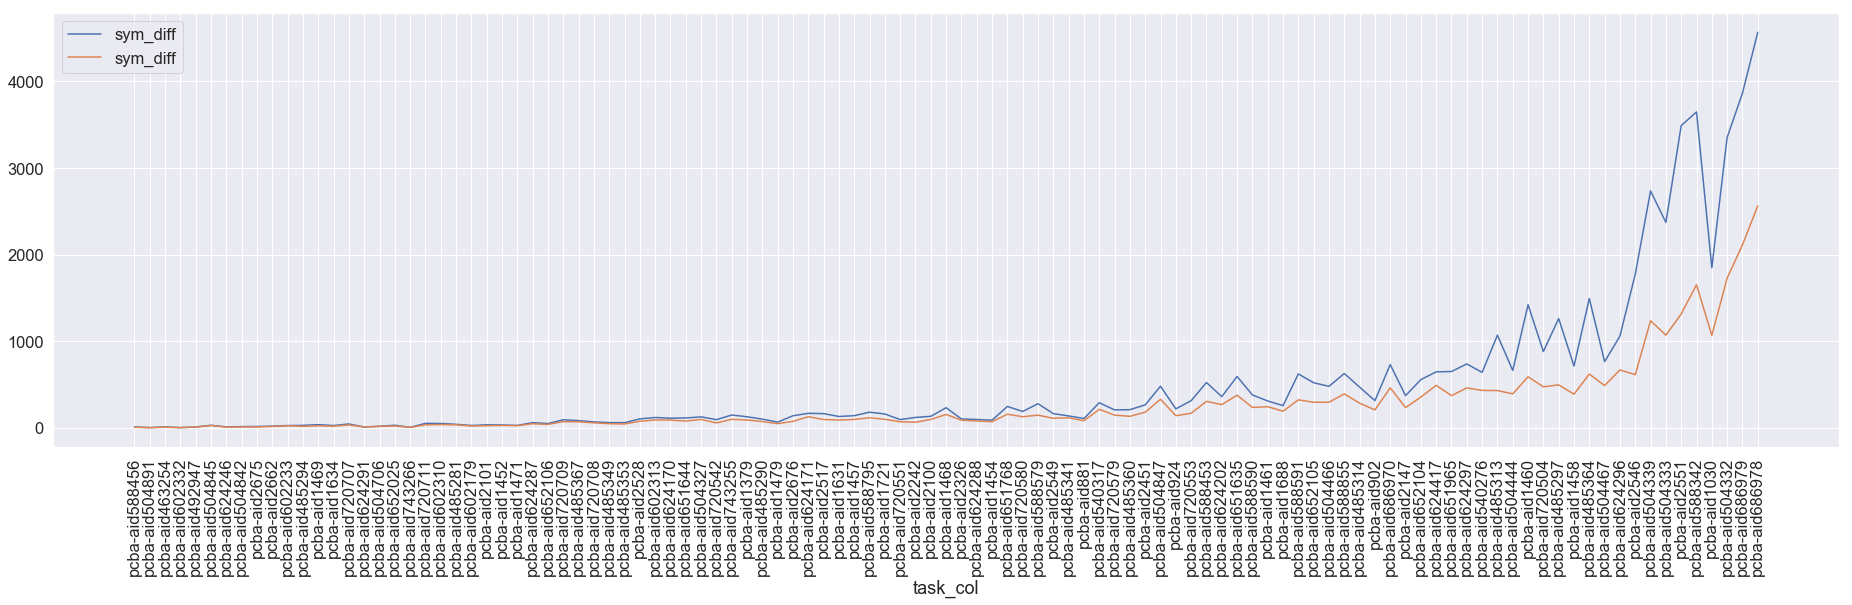

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper")
sns.set(font_scale=1.5)

figsize=(32, 8)
plt.figure(figsize=figsize)
sns.lineplot(x=task_means.index, y=task_means['sym_diff'].values, sort=False)
sns.lineplot(x=task_means.index, y=task_means['sym_diff_u'].values, sort=False)
plt.xticks(rotation=90);
plt.legend(['sym_diff', 'sym_diff'])

In [116]:
task_means

,609_hits,MABE_hits,609_uhits,MABE_uhits,intersect,union,sym_diff,intersect_u,union_u,sym_diff_u,hit_limit,unique_hit_limit,cpd_count,active_ratio
task_col,,,,,,,,,,,,,,
pcba-aid588456,18.9,20.3,13.2,15.3,14.4,24.8,10.4,10.9,17.6,6.7,51.0,36.0,384401.0,0.01
pcba-aid504891,1.3,2.4,1.2,2.0,0.7,3.0,2.3,0.6,2.6,2.0,34.0,29.0,361253.0,0.01
pcba-aid463254,6.2,10.3,4.8,5.8,3.0,13.5,10.5,1.9,8.7,6.8,41.0,32.0,329208.0,0.01
pcba-aid602332,0.6,2.3,0.6,2.3,0.3,2.6,2.3,0.3,2.6,2.3,69.0,66.0,408382.0,0.02
pcba-aid492947,6.1,9.8,5.2,7.4,2.9,13.0,10.1,2.1,10.5,8.4,80.0,66.0,329377.0,0.02
pcba-aid504845,24.2,18.2,22.9,16.8,6.7,35.7,29.0,6.4,33.3,26.9,100.0,91.0,372364.0,0.03
pcba-aid624246,11.7,5.8,7.9,4.3,3.5,14.0,10.5,2.2,10.0,7.8,101.0,84.0,364607.0,0.03
pcba-aid504842,22.2,20.7,13.8,12.3,14.5,28.4,13.9,7.9,18.2,10.3,101.0,85.0,324667.0,0.03
pcba-aid2675,21.0,10.0,14.5,7.0,7.7,23.3,15.6,5.5,16.0,10.5,99.0,84.0,248888.0,0.04


---
# ClusterBasedWSelector_609 look at specific cpd activity vs uncertainty scores
## Why are exploration models able to find many actives?

In [56]:
from active_learning_dd.models.supervised  import *
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper")
sns.set(font_scale=1.5)

root_dir = '../../../aldd_results/params_results_exp3_July_2_2020//params_results\\'

In [114]:
iter_max=1
task_col = 'pcba-aid588591'
af = root_dir+'sampled_hyparams/ClusterBasedWCSelector_609/{}/0/batch_size_96/'.format(task_col)
train_files = [af+'/training_data/iter_{}.csv'.format(i) for i in range(iter_max)]

train_df = pd.concat([pd.read_csv(x) for x in train_files])
unlabeled_df = pd.concat([pd.read_csv(x) for x in glob.glob('../datasets/pcba/{}_cv_96/*.csv'.format(task_col))])
unlabeled_df = unlabeled_df.drop_duplicates('Index ID')
unlabeled_df = unlabeled_df[~unlabeled_df['Index ID'].isin(train_df['Index ID'].values)]

X_train = np.vstack([ (np.fromstring(x, 'u1') - ord('0')).astype(np.uint16) for x in train_df['Morgan FP_2_1024'] ])
X_test = np.vstack([ (np.fromstring(x, 'u1') - ord('0')).astype(np.uint16) for x in unlabeled_df['Morgan FP_2_1024'] ])
y_train, y_test = train_df[task_col].values.reshape(-1,1), unlabeled_df[task_col].values.reshape(-1,1)

model = sklearn_randomforest.SklearnRF(task_names=['pcba-aid1030'],
                                       n_estimators=50,
                                       max_features="log2",
                                       min_samples_leaf=1,
                                       n_jobs=1,
                                       class_weight="balanced",
                                       random_state=20183112,
                                       oob_score=False,
                                       verbose=0)
model.fit(X_train, y_train)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
test_uncert = model.get_uncertainty(X_test, 'least_confidence', [])

#test_preds = (test_preds - np.min(test_preds)) / (np.max(test_preds) - np.min(test_preds))
#test_uncert = 1 - (np.abs(2*test_preds - 1))

test_actives = np.where(y_test[:,0] == 1)[0]
test_inactives = np.where(y_test[:,0] == 0)[0]

C:\Users\Moeman\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Moeman\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


Text(0.5, 1.0, 'Unlabeled preds distribution after 1 iterations.')

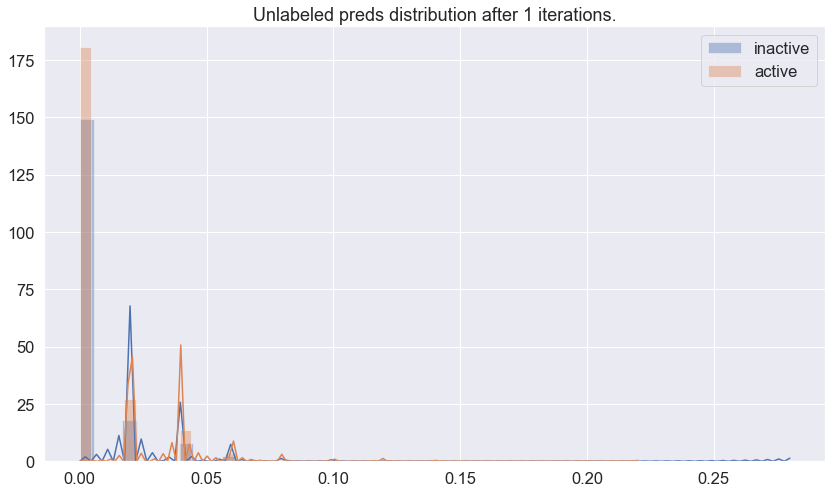

In [115]:
figsize=(14, 8)
plt.figure(figsize=figsize)
sns.distplot(test_preds[test_inactives,0])
sns.distplot(test_preds[test_actives,0])
plt.legend(['inactive', 'active'])
plt.title('Unlabeled preds distribution after {} iterations.'.format(iter_max))

In [116]:
iter_max=50
task_col = 'pcba-aid588591'
af = root_dir+'sampled_hyparams/ClusterBasedWCSelector_609/{}/0/batch_size_96/'.format(task_col)
train_files = [af+'/training_data/iter_{}.csv'.format(i) for i in range(iter_max)]

train_df = pd.concat([pd.read_csv(x) for x in train_files])
unlabeled_df = pd.concat([pd.read_csv(x) for x in glob.glob('../datasets/pcba/{}_cv_96/*.csv'.format(task_col))])
unlabeled_df = unlabeled_df.drop_duplicates('Index ID')
unlabeled_df = unlabeled_df[~unlabeled_df['Index ID'].isin(train_df['Index ID'].values)]

X_train = np.vstack([ (np.fromstring(x, 'u1') - ord('0')).astype(np.uint16) for x in train_df['Morgan FP_2_1024'] ])
X_test = np.vstack([ (np.fromstring(x, 'u1') - ord('0')).astype(np.uint16) for x in unlabeled_df['Morgan FP_2_1024'] ])
y_train, y_test = train_df[task_col].values.reshape(-1,1), unlabeled_df[task_col].values.reshape(-1,1)

model = sklearn_randomforest.SklearnRF(task_names=['pcba-aid1030'],
                                       n_estimators=50,
                                       max_features="log2",
                                       min_samples_leaf=1,
                                       n_jobs=1,
                                       class_weight="balanced",
                                       random_state=20183112,
                                       oob_score=False,
                                       verbose=0)
model.fit(X_train, y_train)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
test_uncert = model.get_uncertainty(X_test, 'least_confidence', [])

#test_preds = (test_preds - np.min(test_preds)) / (np.max(test_preds) - np.min(test_preds))
#test_uncert = 1 - (np.abs(2*test_preds - 1))

test_actives = np.where(y_test[:,0] == 1)[0]
test_inactives = np.where(y_test[:,0] == 0)[0]

C:\Users\Moeman\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Moeman\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


Text(0.5, 1.0, 'Unlabeled preds distribution after 50 iterations.')

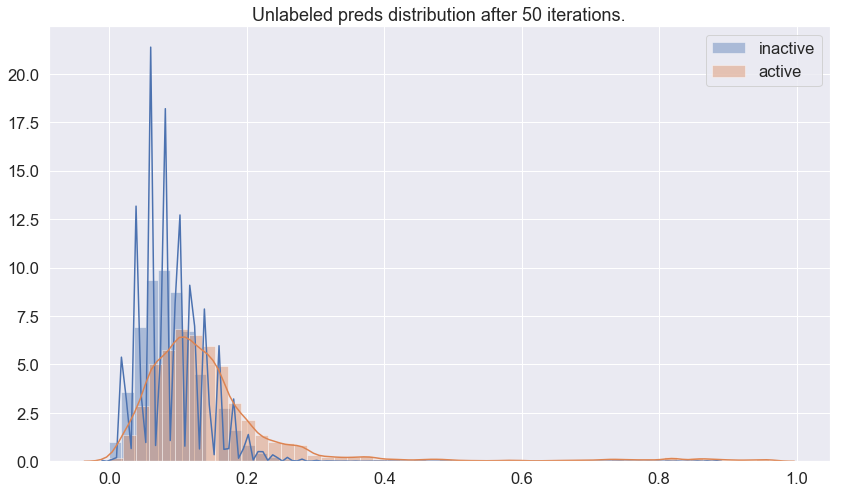

In [117]:
figsize=(14, 8)
plt.figure(figsize=figsize)
sns.distplot(test_preds[test_inactives,0])
sns.distplot(test_preds[test_actives,0])
plt.legend(['inactive', 'active'])
plt.title('Unlabeled preds distribution after {} iterations.'.format(iter_max))

- This explains why exploration-heavy CBWS models are still able to find many actives. 
- Mainly, the range of the preds of random forest are small [0, 0.3] in __early iterations__ which means that activity score AND uncertainty score (distance from 0.5) give same ORDERING. This means that exploration heavy models are effectively doing exploitation with diversity selection as well. 
- To fix/remedy this, we can probably normalize predictions of the tested pool in range from 0-1. This would show that uncertainty scores (distance from 0.5) is clearly different that activity score. 

- So in summary, early iterations it is likely that exploration-heavy and exploitation-heavy select similar cpds since activity vs uncertainty scores are similar, but in late iterations the range of scores becomes wider and so differences arise. 
- Perhaps a random forest method with soft boundaries is not suitable for iterative screening, we should try a neural network, which from our experience has more clear boundaries and wider range of scores early on. But again this can be suspect to overfitting. Perhaps a normalization 0-1 scheme will work too. 